# Description

This notebook analyses the "high polygenicity" problem in our TWAS results from PhenomeXcan and explores ways to fix it. That is, some traits such as "height", are highly polygenic (many genes are correlated with it), and this is a problem for our downstream analysis where these traits (anthropometric ones in particular) are everywhere.

Some approaches to try to fix this issue are explored, such as standardizing by GWAS sample size.

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import conf
from entity import Gene, Trait
from data.cache import read_data
from multiplier import MultiplierProjection

# Settings

# Load PhenomeXcan data (S-MultiXcan)

In [3]:
smultixcan_results_filename = conf.PHENOMEXCAN[
    "SMULTIXCAN_EFO_PARTIAL_MASHR_ZSCORES_FILE"
]

display(smultixcan_results_filename)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/data/phenomexcan/gene_assoc/smultixcan-efo_partial-mashr-zscores.pkl')

In [4]:
results_filename_stem = smultixcan_results_filename.stem
display(results_filename_stem)

'smultixcan-efo_partial-mashr-zscores'

In [5]:
smultixcan_results = pd.read_pickle(smultixcan_results_filename)

In [6]:
smultixcan_results.shape

(22515, 3752)

In [7]:
smultixcan_results.head()

,100001_raw-Food_weight,100002_raw-Energy,100003_raw-Protein,100004_raw-Fat,100005_raw-Carbohydrate,100006_raw-Saturated_fat,100007_raw-Polyunsaturated_fat,100008_raw-Total_sugars,100009_raw-Englyst_dietary_fibre,100010-Portion_size,...,visual impairment,vitiligo,vitreous body disease,vocal cord polyp,voice disorders,wellbeing measurement AND family relationship,wheezing,whooping cough,worry measurement,wrist fracture
gene_name,,,,,,,,,,,,,,,,,,,,,
ENSG00000000419,1.145442,0.724557,0.090876,0.298165,1.134347,1.371138,0.065718,0.794317,0.600342,0.317652,...,0.360518,1.351624,1.157695,0.835289,1.173072,1.337280,1.743822,1.017226,1.512184,0.972241
ENSG00000000457,0.618066,1.028131,2.218420,0.762584,0.934418,0.192993,1.080230,0.765997,0.375898,0.678731,...,2.134504,0.127830,0.534690,0.120516,0.517464,2.545363,0.673331,2.003092,0.344000,2.033122
ENSG00000000460,0.515724,0.403596,1.251359,0.433091,0.413466,0.246261,1.236151,0.827430,0.571985,0.782174,...,1.768905,0.992408,0.548215,0.412341,1.499415,1.366780,0.443318,0.417630,0.225934,1.613246
ENSG00000000938,0.280781,0.253910,0.879148,0.352705,0.051846,0.184212,0.148566,0.009989,0.363751,0.374514,...,0.656552,2.046041,2.746832,0.108211,1.008258,0.755695,0.896228,0.875047,0.476405,1.693057
ENSG00000000971,0.548127,0.389877,0.723469,1.167250,0.315952,0.324939,1.613932,0.311432,0.333548,1.807243,...,0.260482,0.646204,1.080240,0.678330,1.465358,0.307672,0.118376,1.419812,0.000002,1.040737


In [8]:
pd.Series(smultixcan_results.values.flatten()).describe().apply(str)

count             84476280.0
mean      0.8638967105401182
std       0.7355093768129249
min                      0.0
25%      0.33519032841499646
50%       0.7165349117038435
75%       1.2250506784524884
max       52.732309168781974
dtype: object

## Convert gene IDs to Gene names

In [9]:
smultixcan_results = smultixcan_results.rename(index=Gene.GENE_ID_TO_NAME_MAP)

In [10]:
smultixcan_results.shape

(22515, 3752)

In [11]:
smultixcan_results.head()

,100001_raw-Food_weight,100002_raw-Energy,100003_raw-Protein,100004_raw-Fat,100005_raw-Carbohydrate,100006_raw-Saturated_fat,100007_raw-Polyunsaturated_fat,100008_raw-Total_sugars,100009_raw-Englyst_dietary_fibre,100010-Portion_size,...,visual impairment,vitiligo,vitreous body disease,vocal cord polyp,voice disorders,wellbeing measurement AND family relationship,wheezing,whooping cough,worry measurement,wrist fracture
gene_name,,,,,,,,,,,,,,,,,,,,,
DPM1,1.145442,0.724557,0.090876,0.298165,1.134347,1.371138,0.065718,0.794317,0.600342,0.317652,...,0.360518,1.351624,1.157695,0.835289,1.173072,1.337280,1.743822,1.017226,1.512184,0.972241
SCYL3,0.618066,1.028131,2.218420,0.762584,0.934418,0.192993,1.080230,0.765997,0.375898,0.678731,...,2.134504,0.127830,0.534690,0.120516,0.517464,2.545363,0.673331,2.003092,0.344000,2.033122
C1orf112,0.515724,0.403596,1.251359,0.433091,0.413466,0.246261,1.236151,0.827430,0.571985,0.782174,...,1.768905,0.992408,0.548215,0.412341,1.499415,1.366780,0.443318,0.417630,0.225934,1.613246
FGR,0.280781,0.253910,0.879148,0.352705,0.051846,0.184212,0.148566,0.009989,0.363751,0.374514,...,0.656552,2.046041,2.746832,0.108211,1.008258,0.755695,0.896228,0.875047,0.476405,1.693057
CFH,0.548127,0.389877,0.723469,1.167250,0.315952,0.324939,1.613932,0.311432,0.333548,1.807243,...,0.260482,0.646204,1.080240,0.678330,1.465358,0.307672,0.118376,1.419812,0.000002,1.040737


## Remove duplicated gene entries

In [12]:
smultixcan_results.index[smultixcan_results.index.duplicated(keep="first")]

Index(['SPATA13', 'LINC01422', 'LINC00484', 'MAL2', 'GOLGA8M', 'LINC01115',
       'LYNX1'],
      dtype='object', name='gene_name')

In [13]:
smultixcan_results = smultixcan_results.loc[
    ~smultixcan_results.index.duplicated(keep="first")
]

In [14]:
smultixcan_results.shape

(22508, 3752)

## Some checks

In [15]:
# the data should have no NaN values
assert smultixcan_results.shape == smultixcan_results.dropna(how="any").shape

# Project original S-MultiXcan into MultiPLIER latent space

In [16]:
mproj = MultiplierProjection()

In [17]:
smultixcan_into_multiplier = mproj.transform(smultixcan_results)

In [18]:
smultixcan_into_multiplier.shape

(987, 3752)

In [19]:
smultixcan_into_multiplier.head()

,100001_raw-Food_weight,100002_raw-Energy,100003_raw-Protein,100004_raw-Fat,100005_raw-Carbohydrate,100006_raw-Saturated_fat,100007_raw-Polyunsaturated_fat,100008_raw-Total_sugars,100009_raw-Englyst_dietary_fibre,100010-Portion_size,...,visual impairment,vitiligo,vitreous body disease,vocal cord polyp,voice disorders,wellbeing measurement AND family relationship,wheezing,whooping cough,worry measurement,wrist fracture
LV1,-0.018529,-0.043848,-0.021517,-0.030494,-0.017478,-0.012389,-0.018080,-0.008115,-0.049653,-0.033758,...,-0.006722,-0.003278,-0.010568,-0.005974,0.001363,-0.013469,-0.005827,0.004966,0.045035,0.040176
LV2,0.052884,-0.012038,-0.028537,-0.052565,0.003748,-0.054685,-0.032014,0.009900,-0.030171,0.006873,...,-0.030605,-0.033658,0.018575,0.004952,-0.013827,0.052846,0.034227,-0.032056,-0.013700,0.022791
LV3,-0.003728,-0.011876,0.009331,0.000325,-0.003800,-0.000113,-0.001198,-0.013454,-0.024918,-0.020363,...,-0.000163,-0.022459,-0.019675,-0.045772,0.006908,0.007226,0.047864,0.030882,0.088102,0.021724
LV4,0.028337,-0.006139,0.007777,-0.039561,-0.000932,-0.039758,-0.043279,0.007249,-0.002642,-0.003982,...,-0.018550,0.010721,-0.043519,-0.030809,-0.037809,0.043944,0.025969,-0.047666,-0.006620,0.054820
LV5,-0.015548,0.006967,0.012694,0.006179,-0.000663,0.032299,-0.028889,-0.002338,0.029388,0.008235,...,0.023042,-0.023190,0.010424,-0.007029,0.010276,-0.015197,-0.019299,-0.007524,-0.026164,0.049784


## Quick analysis

List top traits associated to some LVs when the original data is projected.

In [20]:
smultixcan_into_multiplier.loc["LV603"].sort_values(ascending=False).head(20)

30000_raw-White_blood_cell_leukocyte_count    0.339285
30130_raw-Monocyte_count                      0.309447
50_raw-Standing_height                        0.298543
30100_raw-Mean_platelet_thrombocyte_volume    0.293013
30180_raw-Lymphocyte_percentage               0.291032
30140_raw-Neutrophill_count                   0.283304
body height                                   0.264087
30200_raw-Neutrophill_percentage              0.258095
leukocyte count                               0.255670
30150-Eosinophill_count                       0.246918
myeloid white cell count                      0.240056
monocyte count                                0.239372
granulocyte count                             0.227016
sum of neutrophil and eosinophil counts       0.226620
30090_raw-Platelet_crit                       0.226562
30080_raw-Platelet_count                      0.225581
sum of basophil and neutrophil counts         0.221290
neutrophil count                              0.219480
30110_raw-

In [21]:
smultixcan_into_multiplier.loc["LV136"].sort_values(ascending=False).head(20)

5132_raw-3mm_strong_meridian_right                        0.267583
5134_raw-6mm_strong_meridian_left                         0.250203
5099_raw-3mm_weak_meridian_right                          0.246634
coronary artery disease                                   0.242014
5133_raw-6mm_strong_meridian_right                        0.237800
5098_raw-6mm_weak_meridian_right                          0.234193
5096_raw-3mm_weak_meridian_left                           0.231896
5097_raw-6mm_weak_meridian_left                           0.228752
5135_raw-3mm_strong_meridian_left                         0.225642
I9_CORATHER-Coronary_atherosclerosis                      0.173063
I9_IHD-Ischaemic_heart_disease_wide_definition            0.172855
4079_raw-Diastolic_blood_pressure_automated_reading       0.172370
hearing loss                                              0.146664
I9_MI-Myocardial_infarction                               0.129660
I9_MI_STRICT-Myocardial_infarction_strict                 0.12

In [22]:
smultixcan_into_multiplier.loc["LV844"].sort_values(ascending=False).head(20)

celiac disease                                                0.648623
rheumatoid arthritis                                          0.590315
K11_COELIAC-Coeliac_disease                                   0.506841
malabsorption syndrome                                        0.474485
30000_raw-White_blood_cell_leukocyte_count                    0.342640
30110_raw-Platelet_distribution_width                         0.318122
systemic lupus erythematosus                                  0.310763
30140_raw-Neutrophill_count                                   0.305687
leukocyte count                                               0.305495
30270_raw-Mean_sphered_cell_volume                            0.272869
2986-Started_insulin_within_one_year_diagnosis_of_diabetes    0.271690
psoriasis                                                     0.268846
30260_raw-Mean_reticulocyte_volume                            0.266955
6144_3-Never_eat_eggs_dairy_wheat_sugar_Wheat_products        0.260068
lympho

# Select traits

## Get sample size for all traits

Since some PhenomeXcan traits were previously combined into EFO terms, here I need to compute the sample size for meta-analyzed traits (cases were several PhenomeXcan's traits mapped to the same EFO term).

In [23]:
df_dicts = []

for trait_name in smultixcan_results.columns:
    if Trait.is_efo_label(trait_name):
        # if it is an EFO label, then sum sample sizes of mapped PhenomeXcan
        # traits.
        traits_list = Trait.get_traits_from_efo(trait_name)

        n_list = [t.n for t in traits_list]
        n_cases_list = [t.n_cases for t in traits_list]
        n_controls_list = [t.n_controls for t in traits_list]

        trait_info = {
            "trait": trait_name,
            "n": sum(n_list),
            "n_cases": sum(n_cases_list),
            "n_controls": sum(n_controls_list),
        }
    else:
        t = Trait.get_trait(full_code=trait_name)
        trait_info = {
            "trait": trait_name,
            "n": t.n,
            "n_cases": t.n_cases,
            "n_controls": t.n_controls,
        }

    df_dicts.append(trait_info)

In [24]:
_tmp = len(df_dicts)
display(_tmp)
assert _tmp == smultixcan_results.shape[1]

3752

In [25]:
traits_sample_size_df = pd.DataFrame(df_dicts).set_index("trait")

In [26]:
assert traits_sample_size_df.index.is_unique

In [27]:
traits_sample_size_df.shape

(3752, 3)

In [28]:
traits_sample_size_df.head()

,n,n_cases,n_controls
trait,,,
100001_raw-Food_weight,51453,NaN,NaN
100002_raw-Energy,51453,NaN,NaN
100003_raw-Protein,51453,NaN,NaN
100004_raw-Fat,51453,NaN,NaN
100005_raw-Carbohydrate,51453,NaN,NaN


In [29]:
# some testing
_tmp = traits_sample_size_df.loc["100001_raw-Food_weight"]
assert _tmp.n == 51453
assert pd.isnull(_tmp.n_cases)
assert pd.isnull(_tmp.n_controls)

_tmp = traits_sample_size_df.loc["estrogen-receptor negative breast cancer"]
assert _tmp.n == 120000
assert _tmp.n_cases == 31000
assert _tmp.n_controls == 89000

_tmp = traits_sample_size_df.loc["eosinophil count"]
assert _tmp.n == 173480
assert pd.isnull(_tmp.n_cases)
assert pd.isnull(_tmp.n_controls)

_tmp = traits_sample_size_df.loc["injury"]
assert _tmp.n == 3250693
assert _tmp.n_cases == 4939
assert _tmp.n_controls == 3245754

_tmp = traits_sample_size_df.loc["asthma"]
assert _tmp.n == 814122
assert _tmp.n_cases == 55344
assert _tmp.n_controls == 758778

## Select representative traits

Here I select some representative traits for downstream analyses in this notebook. The idea is to pick some traits with different sample sizes, and then see what happens before and after a standardization approach.

In [30]:
traits_sample_size_df.sort_values("n").dropna()

,n,n_cases,n_controls
trait,,,
22174-Recent_medication_for_bronchiectasis,819,410.0,409.0
41218_2-History_of_psychiatric_care_on_admission_One_or_more_previous_psychiatric_episodes_with_another_Health_Care_Provider,835,135.0,700.0
20504-Ongoing_addiction_or_dependence_to_overthecounter_medication,977,420.0,557.0
22169-Recent_medication_for_chronic_bronchitis,1048,219.0,829.0
22170-Recent_medication_for_COPD_Chronic_Obstructive_Pulmonary_Disease,1357,991.0,366.0
...,...,...,...
skin disease,2167164,5935.0,2161229.0
checkup,2528358,13708.0,2514650.0
encounter with health service,2528358,9480.0,2518878.0


In [31]:
traits_sample_size_df.sort_values("n_cases").dropna()

,n,n_cases,n_controls
trait,,,
abnormal foot morphology,361194,100.0,361094.0
22617_8124-Job_SOC_coding_Energy_plant_operatives,91149,101.0,91048.0
20003_1140879762-Treatmentmedication_code_celiprolol,361141,101.0,361040.0
22617_3213-Job_SOC_coding_Paramedics,91149,101.0,91048.0
bacterial sexually transmitted disease,361194,101.0,361093.0
...,...,...,...
2207-Wears_glasses_or_contact_lenses,360677,321768.0,38909.0
670_1-Type_of_accommodation_lived_in_A_house_or_bungalow,360088,326854.0,33234.0
2129-Answered_sexual_history_questions,361015,331404.0,29611.0


In [32]:
traits_list = [
    "body height",  # continuous, large n
    "asthma",  # binary, large n and n_cases (meta-analyzed)
    "22174-Recent_medication_for_bronchiectasis",  # lowest n
    "abnormal foot morphology",  # lowest n_cases
]

# Functions

In [33]:
def get_n(trait_name, simple=True):
    """
    Given a trait name, it returns either the `sqrt(n)`, that is the total sample size (when simple=True),
    or `(t.n_cases / t.n_controls) * np.sqrt(t.n)` (when simple=False).
    """
    t = traits_sample_size_df.loc[trait_name]
    if simple:
        return np.sqrt(t.n)

    if not pd.isnull(t.n_cases) and not pd.isnull(t.n_controls):
        return (t.n_cases / t.n_controls) * np.sqrt(t.n)
    else:
        return np.sqrt(t.n)

In [34]:
def show_hist(trait_names, data):
    """
    Shows a density plot (KDE) for a trait given a data version.
    """
    _df = (
        data[trait_names]
        .stack()
        .reset_index()
        .rename(columns={"level_1": "trait", 0: "z-score"})
    )
    return sns.displot(_df, x="z-score", hue="trait", rug=False, kind="kde")

# Approach \#1: Standardize by GWAS sample size

For each trait (column), divide by $sqrt(n)$, where $n$ is the sample size in the GWAS for the trait.

## Standardize

In [35]:
_tmp = smultixcan_results.apply(lambda x: x / get_n(x.name, simple=True))

In [36]:
_tmp.shape

(22508, 3752)

In [37]:
assert _tmp.shape == smultixcan_results.shape

In [38]:
_tmp.head()

,100001_raw-Food_weight,100002_raw-Energy,100003_raw-Protein,100004_raw-Fat,100005_raw-Carbohydrate,100006_raw-Saturated_fat,100007_raw-Polyunsaturated_fat,100008_raw-Total_sugars,100009_raw-Englyst_dietary_fibre,100010-Portion_size,...,visual impairment,vitiligo,vitreous body disease,vocal cord polyp,voice disorders,wellbeing measurement AND family relationship,wheezing,whooping cough,worry measurement,wrist fracture
gene_name,,,,,,,,,,,,,,,,,,,,,
DPM1,0.005050,0.003194,0.000401,0.001314,0.005001,0.006045,0.000290,0.003502,0.002647,0.001401,...,0.000600,0.002249,0.001926,0.001390,0.001952,0.003880,0.002929,0.001693,2.568834e-03,0.000934
SCYL3,0.002725,0.004533,0.009780,0.003362,0.004119,0.000851,0.004762,0.003377,0.001657,0.002993,...,0.003552,0.000213,0.000890,0.000201,0.000861,0.007384,0.001131,0.003333,5.843724e-04,0.001953
C1orf112,0.002274,0.001779,0.005517,0.001909,0.001823,0.001086,0.005450,0.003648,0.002522,0.003449,...,0.002943,0.001651,0.000912,0.000686,0.002495,0.003965,0.000745,0.000695,3.838072e-04,0.001550
FGR,0.001238,0.001119,0.003876,0.001555,0.000229,0.000812,0.000655,0.000044,0.001604,0.001651,...,0.001092,0.003405,0.004570,0.000180,0.001678,0.002192,0.001505,0.001456,8.092970e-04,0.001627
CFH,0.002416,0.001719,0.003189,0.005146,0.001393,0.001433,0.007115,0.001373,0.001470,0.007969,...,0.000433,0.001075,0.001797,0.001129,0.002438,0.000893,0.000199,0.002363,3.656034e-09,0.001000


In [39]:
# some testing
_trait = "100001_raw-Food_weight"
_gene = "DPM1"
assert _tmp.loc[_gene, _trait] == smultixcan_results.loc[_gene, _trait] / np.sqrt(51453)

_trait = "asthma"
_gene = "C1orf112"
assert _tmp.loc[_gene, _trait] == smultixcan_results.loc[_gene, _trait] / np.sqrt(
    814122
)

In [40]:
smultixcan_results_std = _tmp

## Analyze distributions

Text(0.5, 1.0, 'Original distribution')

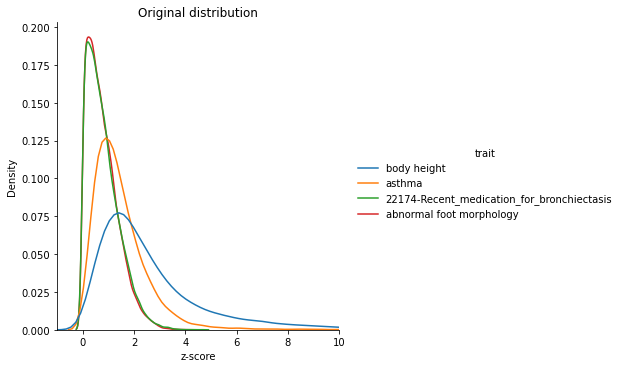

In [41]:
fg = show_hist(traits_list, data=smultixcan_results)
ax = fg.axes[0, 0]
ax.set_xlim(-1, 10)
ax.set_title("Original distribution")

In the original distribution, `body height` has a very long tail, and it has larger values on average than the rest.
`asthma` is behind `body height`, and the other two traits (with very low sample size) are, as expected, closer to zero.

Text(0.5, 1.0, 'Standardized by $sqrt(n)$')

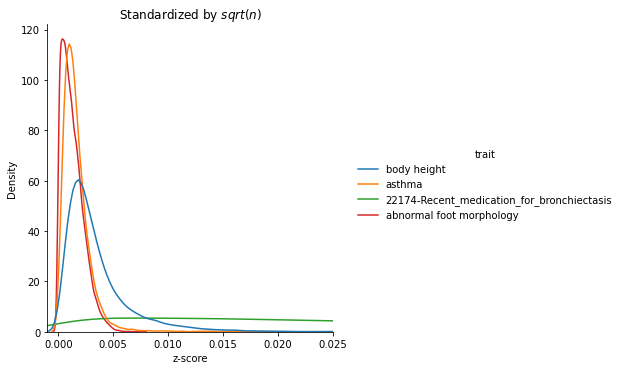

In [42]:
fg = show_hist(traits_list, data=smultixcan_results_std)
ax = fg.axes[0, 0]
ax.set_xlim(-0.001, 0.025)
ax.set_title("Standardized by $sqrt(n)$")

This standardization approach make `asthma` closer to one of the low-sample-sized traits, height is still "highly polygenic", and the weirdest thing is that very low sample size trait `recent medication...` has now very large values compared with the others.

This won't work.

## Projection

Here I use the standardized data and project it into the latent space, and I see what happens with well-known LVs: LV603 (related to neutrophils and white blood cells) and LV136 (cardiovascular traits and keratometry measurements).

In [43]:
mproj = MultiplierProjection()

In [44]:
smultixcan_into_multiplier = mproj.transform(smultixcan_results_std)

In [45]:
smultixcan_into_multiplier.shape

(987, 3752)

In [46]:
smultixcan_into_multiplier.head()

,100001_raw-Food_weight,100002_raw-Energy,100003_raw-Protein,100004_raw-Fat,100005_raw-Carbohydrate,100006_raw-Saturated_fat,100007_raw-Polyunsaturated_fat,100008_raw-Total_sugars,100009_raw-Englyst_dietary_fibre,100010-Portion_size,...,visual impairment,vitiligo,vitreous body disease,vocal cord polyp,voice disorders,wellbeing measurement AND family relationship,wheezing,whooping cough,worry measurement,wrist fracture
LV1,0.000205,-0.020544,0.003031,-0.005271,0.003419,0.012647,0.006661,0.007055,-0.020779,-0.009888,...,-0.017031,-0.016621,-0.017459,-0.018140,-0.011245,-0.007523,-0.012872,-0.014282,0.000321,-0.013952
LV2,0.064111,0.013636,-0.006404,-0.022587,0.027137,-0.023493,-0.007186,0.033194,-0.002331,0.024981,...,-0.024857,-0.025876,-0.009527,-0.013400,-0.019821,0.030961,-0.001649,-0.026390,-0.017323,-0.017033
LV3,0.030777,0.027502,0.045722,0.035934,0.033606,0.034044,0.031549,0.025054,0.009962,0.016061,...,-0.020529,-0.029994,-0.027335,-0.037370,-0.018280,0.009186,-0.001381,-0.012048,0.010488,-0.029618
LV4,0.028846,0.001286,0.007168,-0.026319,0.007073,-0.026489,-0.032254,0.016995,0.006577,0.000971,...,-0.012688,-0.003925,-0.021440,-0.016101,-0.019641,0.027819,0.001020,-0.021898,-0.010898,-0.001542
LV5,-0.000309,0.022682,0.027556,0.022262,0.015454,0.044702,-0.008850,0.013707,0.043701,0.021219,...,-0.003040,-0.019058,-0.007593,-0.013539,-0.006958,-0.007479,-0.019330,-0.013012,-0.020364,-0.008273


In [47]:
_tmp = smultixcan_into_multiplier.loc["LV603"].sort_values(ascending=False).head(20)
display(_tmp)

22169-Recent_medication_for_chronic_bronchitis                                                                                  0.758426
41218_2-History_of_psychiatric_care_on_admission_One_or_more_previous_psychiatric_episodes_with_another_Health_Care_Provider    0.586444
22174-Recent_medication_for_bronchiectasis                                                                                      0.583021
20432-Ongoing_behavioural_or_miscellanous_addiction                                                                             0.529347
41218_1-History_of_psychiatric_care_on_admission_One_or_more_previous_psychiatric_episodes_with_this_Health_Care_Provider       0.523809
22170-Recent_medication_for_COPD_Chronic_Obstructive_Pulmonary_Disease                                                          0.495239
20114_1-Illnesses_of_adopted_siblings_Heart_disease                                                                             0.459041
20504-Ongoing_addiction_or_dependence_to_

In [48]:
traits_sample_size_df.loc[_tmp.index[0]]

n             1048.0
n_cases        219.0
n_controls     829.0
Name: 22169-Recent_medication_for_chronic_bronchitis, dtype: float64

In [49]:
_tmp = smultixcan_into_multiplier.loc["LV136"].sort_values(ascending=False).head(20)
display(_tmp)

41218_2-History_of_psychiatric_care_on_admission_One_or_more_previous_psychiatric_episodes_with_another_Health_Care_Provider    0.519451
41220_3-Anaesthetics_administered_post_delivery_Spinal_anaesthetic                                                              0.462763
22169-Recent_medication_for_chronic_bronchitis                                                                                  0.437080
20432-Ongoing_behavioural_or_miscellanous_addiction                                                                             0.407840
22170-Recent_medication_for_COPD_Chronic_Obstructive_Pulmonary_Disease                                                          0.313396
5959-Previously_smoked_cigarettes_on_mostall_days                                                                               0.306376
41218_1-History_of_psychiatric_care_on_admission_One_or_more_previous_psychiatric_episodes_with_this_Health_Care_Provider       0.300521
20113_3-Illnesses_of_adopted_mother_Lung_

In [50]:
traits_sample_size_df.loc[_tmp.index[0]]

n             835.0
n_cases       135.0
n_controls    700.0
Name: 41218_2-History_of_psychiatric_care_on_admission_One_or_more_previous_psychiatric_episodes_with_another_Health_Care_Provider, dtype: float64

**Conclusion:** as anticipated, this standardization approach breaks expected relationships, and makes low sample size traits to be at the top, presenting random associations.

# Approach \#2: Standardize by GWAS sample size considering n_cases and n_controls

Here I take into account the ratio `n_cases / n_controls` (in binary traits) in the standardization, by doing: `(n_cases / n_controls) * sqrt(n)`

## Standardize

In [51]:
_tmp = smultixcan_results.apply(lambda x: x / get_n(x.name, simple=False))

In [52]:
_tmp.shape

(22508, 3752)

In [53]:
assert _tmp.shape == smultixcan_results.shape

In [54]:
_tmp.head()

,100001_raw-Food_weight,100002_raw-Energy,100003_raw-Protein,100004_raw-Fat,100005_raw-Carbohydrate,100006_raw-Saturated_fat,100007_raw-Polyunsaturated_fat,100008_raw-Total_sugars,100009_raw-Englyst_dietary_fibre,100010-Portion_size,...,visual impairment,vitiligo,vitreous body disease,vocal cord polyp,voice disorders,wellbeing measurement AND family relationship,wheezing,whooping cough,worry measurement,wrist fracture
gene_name,,,,,,,,,,,,,,,,,,,,,
DPM1,0.005050,0.003194,0.000401,0.001314,0.005001,0.006045,0.000290,0.003502,0.002647,0.001401,...,0.386309,7.733548,1.551127,3.258136,1.245852,0.003880,0.011135,1.500278,2.816021e-03,0.298476
SCYL3,0.002725,0.004533,0.009780,0.003362,0.004119,0.000851,0.004762,0.003377,0.001657,0.002993,...,2.287206,0.731404,0.716400,0.470086,0.549569,0.007384,0.004300,2.954303,6.406038e-04,0.624165
C1orf112,0.002274,0.001779,0.005517,0.001909,0.001823,0.001086,0.005450,0.003648,0.002522,0.003449,...,1.895452,5.678230,0.734521,1.608380,1.592443,0.003965,0.002831,0.615950,4.207391e-04,0.495264
FGR,0.001238,0.001119,0.003876,0.001555,0.000229,0.000812,0.000655,0.000044,0.001604,0.001651,...,0.703521,11.706773,3.680319,0.422090,1.070813,0.002192,0.005723,1.290582,8.871718e-04,0.519766
CFH,0.002416,0.001719,0.003189,0.005146,0.001393,0.001433,0.007115,0.001373,0.001470,0.007969,...,0.279117,3.697363,1.447349,2.645899,1.556273,0.000893,0.000756,2.094041,4.007837e-09,0.319505


In [55]:
# some testing
_trait = "100001_raw-Food_weight"
_gene = "DPM1"
assert _tmp.loc[_gene, _trait] == smultixcan_results.loc[_gene, _trait] / np.sqrt(51453)

_trait = "estrogen-receptor negative breast cancer"
_gene = "CFH"
assert _tmp.loc[_gene, _trait] == smultixcan_results.loc[_gene, _trait] / (
    (31000 / 89000) * np.sqrt(120000)
)

_trait = "asthma"
_gene = "C1orf112"
assert _tmp.loc[_gene, _trait] == smultixcan_results.loc[_gene, _trait] / (
    (55344 / 758778) * np.sqrt(814122)
)

In [56]:
smultixcan_results_std = _tmp

## Analyze distributions

Text(0.5, 1.0, 'Original distribution')

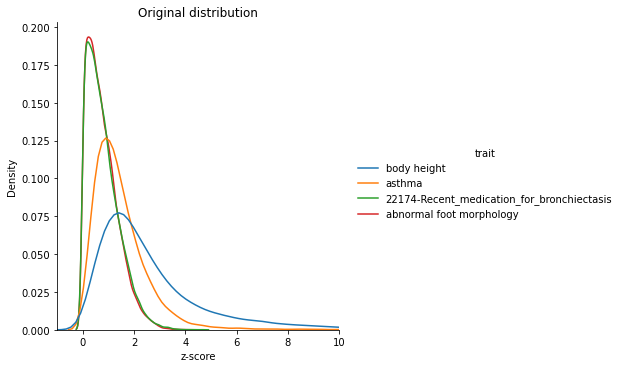

In [57]:
fg = show_hist(traits_list, data=smultixcan_results)
ax = fg.axes[0, 0]
ax.set_xlim(-1, 10)
ax.set_title("Original distribution")

Text(0.5, 1.0, 'Standardized by $(n\\_cases / n\\_controls) * sqrt(n)$')

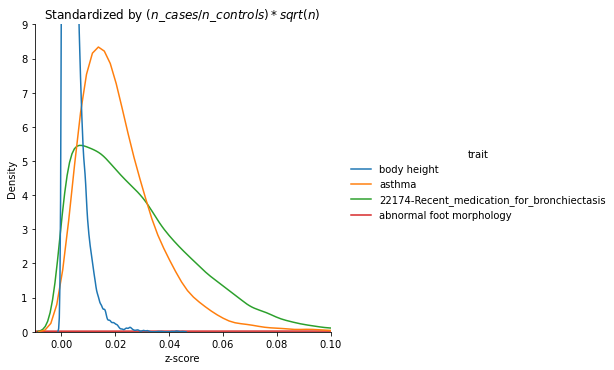

In [58]:
fg = show_hist(traits_list, data=smultixcan_results_std)
ax = fg.axes[0, 0]
ax.set_xlim(-0.01, 0.10)
ax.set_ylim(0, 9)
ax.set_title("Standardized by $(n\_cases / n\_controls) * sqrt(n)$")

Here `asthma` is now more to the right compared with `height`, but the low sample size traits have now too large values.

## Projection

In [59]:
mproj = MultiplierProjection()

In [60]:
smultixcan_into_multiplier = mproj.transform(smultixcan_results_std)

In [61]:
smultixcan_into_multiplier.shape

(987, 3752)

In [62]:
smultixcan_into_multiplier.head()

,100001_raw-Food_weight,100002_raw-Energy,100003_raw-Protein,100004_raw-Fat,100005_raw-Carbohydrate,100006_raw-Saturated_fat,100007_raw-Polyunsaturated_fat,100008_raw-Total_sugars,100009_raw-Englyst_dietary_fibre,100010-Portion_size,...,visual impairment,vitiligo,vitreous body disease,vocal cord polyp,voice disorders,wellbeing measurement AND family relationship,wheezing,whooping cough,worry measurement,wrist fracture
LV1,-0.028208,-0.028251,-0.028207,-0.028219,-0.028198,-0.028178,-0.028194,-0.028194,-0.028250,-0.028224,...,0.000383,0.120043,0.007720,0.069319,0.006375,-0.028223,-0.028081,0.014211,-0.028200,-0.013370
LV2,-0.026612,-0.026715,-0.026751,-0.026787,-0.026687,-0.026790,-0.026753,-0.026672,-0.026738,-0.026683,...,-0.013696,0.045199,0.015364,0.080350,-0.007553,-0.026674,-0.026546,-0.010310,-0.026775,-0.014442
LV3,-0.039764,-0.039770,-0.039732,-0.039752,-0.039756,-0.039758,-0.039755,-0.039774,-0.039805,-0.039796,...,0.006445,0.131781,0.006001,0.039494,0.009288,-0.039812,-0.039520,0.040328,-0.039794,-0.022999
LV4,-0.013979,-0.014041,-0.014031,-0.014104,-0.014028,-0.014100,-0.014124,-0.014010,-0.014034,-0.014049,...,-0.006200,0.085562,-0.019263,-0.003323,-0.015987,-0.013992,-0.013938,-0.020137,-0.014073,-0.002200
LV5,-0.021814,-0.021761,-0.021746,-0.021764,-0.021779,-0.021713,-0.021833,-0.021785,-0.021718,-0.021769,...,0.013245,0.048502,0.015323,0.055829,0.007987,-0.021831,-0.021814,0.007725,-0.021862,-0.008218


In [63]:
_tmp = smultixcan_into_multiplier.loc["LV603"].sort_values(ascending=False).head(20)
display(_tmp)

D3_BLOODNAS-Other_and_unspecified_diseases_of_blood_and_bloodforming_organs                           0.281144
D63-Diagnoses_main_ICD10_D63_Anaemia_in_chronic_diseases_classified_elsewhere                         0.273394
20003_1140866804-Treatmentmedication_code_inderal_10mg_tablet                                         0.271277
H7_CORNULCER-Corneal_ulcer                                                                            0.264494
20003_1140922714-Treatmentmedication_code_dorzolamide                                                 0.264443
nervous system injury                                                                                 0.257529
20003_1140888512-Treatmentmedication_code_amiloride                                                   0.254875
crush injury                                                                                          0.251924
C_SECONDARY_RESPIRATORY_DIGESTIVE-Secondary_malignant_neoplasm_of_respiratory_and_digestive_organs    0.250315
M

In [64]:
traits_sample_size_df.loc[_tmp.index[0]]

n             361194.0
n_cases          123.0
n_controls    361071.0
Name: D3_BLOODNAS-Other_and_unspecified_diseases_of_blood_and_bloodforming_organs, dtype: float64

In [65]:
_tmp = smultixcan_into_multiplier.loc["LV136"].sort_values(ascending=False).head(20)
display(_tmp)

20003_2038460068-Treatmentmedication_code_phenobarbitone                                              0.276007
20003_1140879798-Treatmentmedication_code_terazosin                                                   0.257145
abnormality of male internal genitalia                                                                0.234924
20003_1140877826-Treatmentmedication_code_sodium_bicarbonate                                          0.227962
41248_7001-Destinations_on_discharge_from_hospital_recoded_Nursing_residential_care_group_home_NHS    0.217427
20003_1140878172-Treatmentmedication_code_tears_naturale_eye_drops                                    0.210637
sexual dysfunction                                                                                    0.204175
viral meningitis                                                                                      0.198256
RHEUMA_CHRYSTAL-Chrystal_arthropathies_rheuma_endpoint                                                0.197832
o

In [66]:
traits_sample_size_df.loc[_tmp.index[0]]

n             361141.0
n_cases          105.0
n_controls    361036.0
Name: 20003_2038460068-Treatmentmedication_code_phenobarbitone, dtype: float64

**Conclusion:** this approach doesn't work either.

# Approach \#3: Standardize by sum of z-scores

Here I divide all z-scores for a trait by `sum(z)` (sum of z-scores). The idea is that highly polygenic traits would be more penalized, which is what we want.

## Standardize

In [67]:
_tmp = smultixcan_results.apply(lambda x: x / x.sum())

In [68]:
_tmp.shape

(22508, 3752)

In [69]:
assert _tmp.shape == smultixcan_results.shape

In [70]:
_tmp.head()

,100001_raw-Food_weight,100002_raw-Energy,100003_raw-Protein,100004_raw-Fat,100005_raw-Carbohydrate,100006_raw-Saturated_fat,100007_raw-Polyunsaturated_fat,100008_raw-Total_sugars,100009_raw-Englyst_dietary_fibre,100010-Portion_size,...,visual impairment,vitiligo,vitreous body disease,vocal cord polyp,voice disorders,wellbeing measurement AND family relationship,wheezing,whooping cough,worry measurement,wrist fracture
gene_name,,,,,,,,,,,,,,,,,,,,,
DPM1,0.000060,0.000039,0.000005,0.000016,0.000061,0.000075,0.000004,4.254814e-05,0.000031,0.000017,...,0.000020,0.000075,0.000064,0.000047,0.000066,0.000066,0.000069,0.000058,6.250232e-05,0.000034
SCYL3,0.000033,0.000055,0.000119,0.000041,0.000050,0.000011,0.000059,4.103114e-05,0.000020,0.000036,...,0.000118,0.000007,0.000030,0.000007,0.000029,0.000126,0.000027,0.000114,1.421837e-05,0.000070
C1orf112,0.000027,0.000022,0.000067,0.000023,0.000022,0.000014,0.000067,4.432186e-05,0.000030,0.000041,...,0.000098,0.000055,0.000030,0.000023,0.000084,0.000068,0.000018,0.000024,9.338414e-06,0.000056
FGR,0.000015,0.000014,0.000047,0.000019,0.000003,0.000010,0.000008,5.350929e-07,0.000019,0.000020,...,0.000036,0.000114,0.000152,0.000006,0.000057,0.000038,0.000035,0.000050,1.969101e-05,0.000058
CFH,0.000029,0.000021,0.000039,0.000063,0.000017,0.000018,0.000088,1.668206e-05,0.000017,0.000095,...,0.000014,0.000036,0.000060,0.000038,0.000083,0.000015,0.000005,0.000081,8.895497e-11,0.000036


In [71]:
# some testing
_trait = "body height"
_gene = "SCYL3"
assert (
    _tmp.loc[_gene, _trait]
    == smultixcan_results.loc[_gene, _trait] / smultixcan_results[_trait].sum()
)

In [72]:
smultixcan_results_std = _tmp

## Analyze distributions

Text(0.5, 1.0, 'Original distribution')

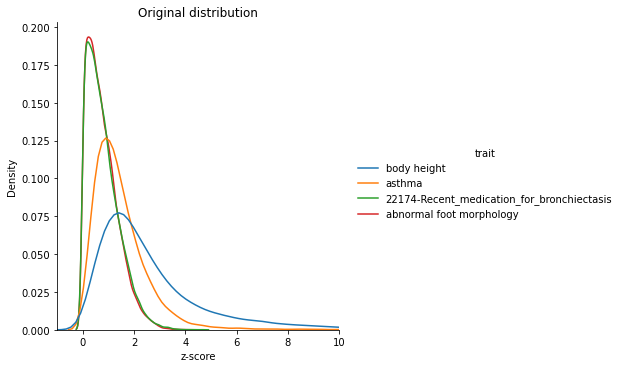

In [73]:
fg = show_hist(traits_list, data=smultixcan_results)
ax = fg.axes[0, 0]
ax.set_xlim(-1, 10)
ax.set_title("Original distribution")

Text(0.5, 1.0, 'Standardized by $sum(zscores)$')

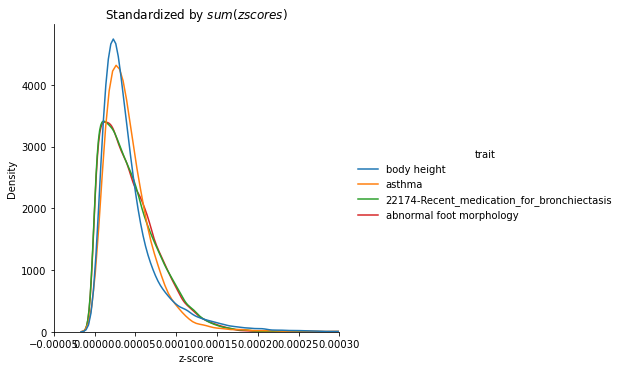

In [74]:
fg = show_hist(traits_list, data=smultixcan_results_std)
ax = fg.axes[0, 0]
ax.set_xlim(-0.00005, 0.0003)
ax.set_title("Standardized by $sum(zscores)$")

Now the distribution makes more sense to me: `asthma` is slightly more towards the right than `height`, and the low sample size traits are at the leftmost.

## Projection

In [75]:
mproj = MultiplierProjection()

In [76]:
smultixcan_into_multiplier = mproj.transform(smultixcan_results_std)

In [77]:
smultixcan_into_multiplier.shape

(987, 3752)

In [78]:
smultixcan_into_multiplier.head()

,100001_raw-Food_weight,100002_raw-Energy,100003_raw-Protein,100004_raw-Fat,100005_raw-Carbohydrate,100006_raw-Saturated_fat,100007_raw-Polyunsaturated_fat,100008_raw-Total_sugars,100009_raw-Englyst_dietary_fibre,100010-Portion_size,...,visual impairment,vitiligo,vitreous body disease,vocal cord polyp,voice disorders,wellbeing measurement AND family relationship,wheezing,whooping cough,worry measurement,wrist fracture
LV1,-0.021292,-0.046815,-0.021585,-0.030324,-0.017773,-0.007844,-0.015529,-0.011609,-0.051342,-0.036813,...,-0.001614,0.002102,-0.005318,-0.003041,0.012873,-0.015951,-0.018904,0.009576,0.019755,0.010027
LV2,0.056061,-0.009864,-0.028888,-0.053573,0.006951,-0.054597,-0.030748,0.014519,-0.026933,0.009024,...,-0.029614,-0.033636,0.020768,0.010656,-0.013305,0.050738,0.012085,-0.032372,-0.024540,-0.002616
LV3,0.001650,-0.004262,0.019211,0.007484,0.004548,0.006548,0.006741,-0.005634,-0.022129,-0.017256,...,0.010539,-0.019591,-0.013391,-0.044369,0.020142,0.006052,0.020869,0.043931,0.058049,-0.013144
LV4,0.026265,-0.007235,0.004304,-0.042464,-0.001093,-0.041208,-0.051179,0.009060,-0.003999,-0.005874,...,-0.018162,0.012136,-0.046232,-0.030949,-0.040147,0.044545,0.009865,-0.049828,-0.013725,0.024988
LV5,-0.015616,0.010799,0.017792,0.010591,0.001972,0.040024,-0.027612,-0.001540,0.033072,0.009477,...,0.030632,-0.023253,0.015853,-0.002222,0.019385,-0.015501,-0.031477,-0.002554,-0.032620,0.017731


In [79]:
_tmp = smultixcan_into_multiplier.loc["LV603"].sort_values(ascending=False).head(20)
display(_tmp)

30220_raw-Basophill_percentage                                   0.181608
30130_raw-Monocyte_count                                         0.158166
30000_raw-White_blood_cell_leukocyte_count                       0.146061
myeloid white cell count                                         0.133998
leukocyte count                                                  0.131486
sum of neutrophil and eosinophil counts                          0.128405
granulocyte count                                                0.128316
sum of basophil and neutrophil counts                            0.126586
neutrophil count                                                 0.125868
30160-Basophill_count                                            0.122953
30180_raw-Lymphocyte_percentage                                  0.119818
30140_raw-Neutrophill_count                                      0.113055
monocyte count                                                   0.113054
20003_1140875420-Treatmentmedication_c

In [80]:
traits_sample_size_df.loc[_tmp.index[0]]

n             349861.0
n_cases            NaN
n_controls         NaN
Name: 30220_raw-Basophill_percentage, dtype: float64

In [81]:
_tmp = smultixcan_into_multiplier.loc["LV136"].sort_values(ascending=False).head(20)
display(_tmp)

coronary artery disease                                           0.210545
5132_raw-3mm_strong_meridian_right                                0.179597
5134_raw-6mm_strong_meridian_left                                 0.167916
5099_raw-3mm_weak_meridian_right                                  0.161459
5133_raw-6mm_strong_meridian_right                                0.160688
5098_raw-6mm_weak_meridian_right                                  0.157502
I9_CORATHER-Coronary_atherosclerosis                              0.154131
5097_raw-6mm_weak_meridian_left                                   0.150595
5096_raw-3mm_weak_meridian_left                                   0.150400
5135_raw-3mm_strong_meridian_left                                 0.149901
I9_IHD-Ischaemic_heart_disease_wide_definition                    0.148814
I9_MI_STRICT-Myocardial_infarction_strict                         0.125965
I9_MI-Myocardial_infarction                                       0.125965
acute myocardial infarcti

In [82]:
traits_sample_size_df.loc[_tmp.index[0]]

n             545499.0
n_cases        73570.0
n_controls    471929.0
Name: coronary artery disease, dtype: float64

In [83]:
_tmp = smultixcan_into_multiplier.loc["LV844"].sort_values(ascending=False).head(20)
display(_tmp)

celiac disease                                                                                  0.714810
rheumatoid arthritis                                                                            0.600279
K11_COELIAC-Coeliac_disease                                                                     0.600040
malabsorption syndrome                                                                          0.570880
2986-Started_insulin_within_one_year_diagnosis_of_diabetes                                      0.350327
6144_3-Never_eat_eggs_dairy_wheat_sugar_Wheat_products                                          0.338204
systemic lupus erythematosus                                                                    0.327493
hyperthyroidism AND thyrotoxicosis                                                              0.309382
20003_1140883066-Treatmentmedication_code_insulin_product                                       0.289095
psoriasis                                              

In [84]:
traits_sample_size_df.loc[_tmp.index[0]]

n             361141.0
n_cases         1587.0
n_controls    359554.0
Name: celiac disease, dtype: float64

**Conclusion:** trait associations with known LVs are preserved with this approach.

# Conclusion

We select the last approach (Approach \#3) for downstream analyses.